In [1]:
!pip install Pillow --quiet
!pip install webdataset==0.1.62
!pip install pytorch-model-summary

  Attempting uninstall: webdataset
    Found existing installation: webdataset 0.1.103
    Uninstalling webdataset-0.1.103:
      Successfully uninstalled webdataset-0.1.103


In [20]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

In [21]:
import webdataset as wds
from itertools import islice
import struct, ast
from importlib_metadata import version

In [3]:
version('webdataset')

'0.1.62'

In [4]:
def plot_raw_EEG(data, n_sample):
    numChan = 24
    if len(data[0]) == 2: # torch batch
        x_data = data[:][0]
    else:
        x_data = data
    row = col = int(np.sqrt(n_sample))
    fig = plt.figure(figsize=(row*10, col*10))
    outer = gridspec.GridSpec(row, col)
    print(n_sample)
    for i in range(n_sample):
        inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                        subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
        npimg = x_data[i,:,:,:]
        npimg = np.reshape(npimg,(numChan,256))
        yax = None
        for j in range(numChan):
            ax = plt.Subplot(fig, inner[j])
            ax.plot(range(256),npimg[j,:],'k')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    return fig

In [114]:
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Where input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
        min_mat = np.expand_dims(np.min(x,axis=3),3)
        print(min_mat.shape)
        assert(min_mat[0,0,0] == np.min(x[0,:,0,:]))
        assert(min_mat[0,0,1] == np.min(x[0,:,1,:]))
        range_mat = np.expand_dims(np.ptp(x,axis=3),axis=3)
        print(range_mat.shape)
        assert(range_mat[0,0,0] == np.max(x[0,:,0,:])-np.min(x[0,:,0,:]))
        assert(range_mat[0,0,1] == np.max(x[0,:,1,:])-np.min(x[0,:,1,:]))
        x = (x - min_mat)/range_mat
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = f[f'Y_{role}']
   
    return EEGDataset(x, y, role=='train', role=='val')

class EEGDataset(Dataset):
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
#         assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

In [115]:
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

AttributeError: module 'numpy' has no attribute 'expand_dim'

In [ ]:
fig = plot_raw_EEG(train_data, 4)

In [80]:
class Logger():
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{self.experiment_name}-{info}")
        
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

isDebug = False

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

latent_dim = 20
print('latent dimension:', str(latent_dim))
def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)


def selectLabel(x,lbl):
    # # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")
    # return x if lbl_idx == 0 else float(x)
    return 1
    
# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
# train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
# val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

using device: cuda
latent dimension: 20


In [99]:
class VAE(nn.Module): 
    
    def __init__(self, latent_dim):
        # latent_dim: dimension of the latent representation vector
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = 1
        self.gamma = 1000.
        self.loss_type = 'H'
        self.C_max = torch.tensor([25])
        self.C_stop_iter = 1e5

        encoder_l = [self.encoder_conv_block(has_maxpool=False, in_channels=1, out_channels=32, kernel_size=6, stride=2, padding=0)]
        encoder_l.append(self.encoder_conv_block(has_maxpool=False, in_channels=32, out_channels=32, kernel_size=6, stride=2, padding=0))
        encoder_l.append(nn.Flatten())
        encoder_l.append(self.encoder_linear_block(6144, 1024))
        encoder_l.append(self.encoder_linear_block(1024, 1024))        
        self.encoder_before_last = nn.ModuleList(encoder_l)
        self.encoder_mu = self.encoder_linear_block(1024, latent_dim)
        self.encoder_log_var = self.encoder_linear_block(1024, latent_dim)
                            
        decoder_l = [self.decoder_linear_block(latent_dim, 1024)]
        decoder_l.append(self.decoder_linear_block(1024, 1024))
        decoder_l.append(self.decoder_linear_block(1024, 6144))
        decoder_l.append(self.decoder_conv_block(has_maxpool=True, in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))
        decoder_l.append(self.decoder_conv_block(has_maxpool=False, in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))
        decoder_l.append(self.decoder_conv_block(has_maxpool=False, in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1))
        decoder_l.append(self.decoder_conv_block(has_maxpool=True, in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1))
        decoder_l.append(self.decoder_conv_block(has_maxpool=False, in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1))
        decoder_l.append(self.decoder_conv_block(has_maxpool=True, in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1))
        decoder_l.append(self.decoder_conv_block(has_maxpool=False, in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1))
        self.decoder = nn.ModuleList(decoder_l)
    
    def encoder_conv_block(self, has_maxpool=False, in_channels=32, out_channels=32, kernel_size=6, stride=2, padding=2):
        if has_maxpool:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
        
    def encoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def decoder_conv_block(self, has_maxpool=False, in_channels=32, out_channels=32, kernel_size=6, stride=2, padding=2):
        if has_maxpool:
            return nn.Sequential(
                nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0),
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU(),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
    
    def decoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def forward(self, x):
        maxpool_indices = []
        for f in self.encoder_before_last:
            if isinstance(f, nn.Flatten):
                x = f(x)
            else:
                for layer in f:
                    if isinstance(layer, nn.MaxPool2d):
                        x, indices = layer(x)
                        maxpool_indices.append(indices)
                    else:
                        x = layer(x)
            print(x.shape)
                
        mu = self.encoder_mu(x)
        log_var = self.encoder_log_var(x)

        z = self.reparameterize(mu, log_var)
        
#         x = self.decoder[0](z)
#         x = x.view(-1, 32, 1, 30) # reshape the tensor to be expected dimension for ConvTranspose
#         for i in range(1,len(self.decoder)):
#             f = self.decoder[i]
#             x = f(x) 
        x = self.decode(z, maxpool_indices)
            
        return x, mu, log_var
    
    def decode(self, z, maxpool_indices):
        x = self.decoder[0](z) # linear(latent_dim, 1024)
        x = self.decoder[1](x) # linear(1024, 1024) 
        x = self.decoder[2](x) # linear(1024, 6144)
        x = x.view(-1, 64, 3, 32) # reshape the tensor to be expected dimension for ConvTranspose
        unpool_idx = len(maxpool_indices)-1
        for i in range(3,len(self.decoder)):
            f = self.decoder[i]
            for layer in f:
                if isinstance(layer, nn.MaxUnpool2d):
                    x = layer(x, maxpool_indices[unpool_idx])
                    unpool_idx = unpool_idx-1
                else:
                    x = layer(x) 
            print(x.shape)
        return x
    
    def generate_sample(self, n_sample):
        z = torch.randn((n_sample, self.latent_dim))
        print(z)
        return self.decode(z)
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def sample_z(self, mu, sigma):
        # Input
        #     mu:     [batch_size, self.latent_size] the predicted mu value for each sample in the batch
        #     sigma:  [batch_size, self.latent_size] the predicted diag elem of sigma value for each sample in the batch
        # Output
        #     z: [batch_size, self.latent_size] the latent representation of each sample in the batch
        # Reference: https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/
        
        # eps ~ N(0,1)        
        batch_size = mu.size()[0]
        eps = torch.randn((batch_size,1), device=device, dtype=dtype)
        z = mu + sigma/2*eps
        z = z.to(device=device)
        return z

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}        

In [100]:
class ToCorrectSizeTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        correct_size_sample = torch.zeros(1,24,256)
        correct_size_sample[0,:,0:28] = sample[0,2:26,:]
        return correct_size_sample

vae = VAE(latent_dim)
vae = vae.to(device=device)

if isDebug:
    mnist_train = torchvision.datasets.MNIST('./mnist', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(),ToCorrectSizeTensor()]))
    mnist_test = torchvision.datasets.MNIST('./mnist', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), ToCorrectSizeTensor()]))
    sample = torch.unsqueeze(mnist_train[0][0],0)
    sample = sample.to(device=device)
else:
    sample = torch.zeros((1, 1, 256, 6), device=device)
print(vae)                         
from pytorch_model_summary import summary
# print(summary(vae, sample, show_input=False)) 
print(summary(vae, sample, show_input=False))

VAE(
  (encoder_before_last): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(6, 6), stride=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(6, 6), stride=(2, 2))
      (1): ReLU()
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Sequential(
      (0): Linear(in_features=6144, out_features=1024, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
    )
  )
  (encoder_mu): Sequential(
    (0): Linear(in_features=1024, out_features=20, bias=True)
    (1): ReLU()
  )
  (encoder_log_var): Sequential(
    (0): Linear(in_features=1024, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=20, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
    )
    (2): 

RuntimeError: Calculated padded input size per channel: (126 x 1). Kernel size: (6 x 6). Kernel size can't be greater than actual input size

KL divergence loss
![kl_loss](https://github.com/dungscout96/deep-representation-learning-EEG/blob/master/images/kl_loss.png?raw=1)

In [70]:
# def beta_vae_loss(mu_hat, sigma_hat, x_hat, x_target):
#     likelihood_loss = F.mse_loss(x_hat, x_target)
#     kl_loss = 0.5 * torch.sum(torch.exp(sigma_hat) + torch.pow(mu_hat,2) - torch.ones((1,mu_hat.size()[1]), device=device, dtype=dtype) - mu_hat, axis=1)
#     return torch.mean(likelihood_loss + kl_loss) # average the loss of batch

def train(model, loader_train, optimizer, loader_val, epochs, logger, device, dtype, M_N):
    """ 
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - logger: Logger object for logging purpose
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_array = []
    num_batch = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print('Begin trainning...')
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            if e == 0:
                num_batch += 1
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            # mu_hat, sigma_hat, x_hat = model(x)
            
            # loss = beta_vae_loss(mu_hat, sigma_hat, x_hat, x)
            
            x_hat, mu_hat, sigma_hat = model(x)
            
            loss_dict = model.loss_function(x_hat, x, mu_hat, sigma_hat,M_N=M_N)
            loss = loss_dict["loss"]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_array.append(loss.item())
            if t % 100 == 0:
                # logger.writer.add_scalar("Loss/train", loss.item(), e*num_batch+t)
                # logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                print(f'Epoch {e}, Iteration {t}, loss = {loss.item()}')
#         train_acc = check_accuracy(loader_train, 'train', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/train", train_acc, e)        
        # get validation loss
#         model.eval()
#         val_loss = check_accuracy(loader_val, 'val', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/valid", val_acc, e)        
#         logger.log()
        
        # Save model per fixed epoch interval
        # if e > 0 and e % 10 == 0:
        #     logger.save_model(model,f"epoch{e}")
#         elif val_acc >= 0.83:
#             logger.save_model(model,f"valacc83-epoch{e}")
#         elif val_acc >= 0.84:
#             logger.save_model(model,f"valacc84-epoch{e}")
    # save final model
    # logger.save_model(model,f"epoch{e}")
    return model, loss_array

In [71]:
vae = VAE(latent_dim)
logger = Logger()
logger.set_model_save_location('VAE')
seed = 0
experiment = f'VAE-seed{seed}'
# logger.set_experiment(experiment)

if isDebug:
    batch_size = 128
    loader_train = DataLoader(mnist_train, batch_size=batch_size)
    loader_val = DataLoader(mnist_test, batch_size=batch_size)
    M_N = len(mnist_train)/batch_size # for VAE
    epochs = 10
else:
    batch_size = 512
    loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_data, batch_size=batch_size)
    M_N = len(train_data)/batch_size # for VAE
    epochs = 100

print('num epochs:', str(epochs))
print('N/M:', str(M_N))

optimizer = torch.optim.Adam(vae.parameters(), lr=0.00001)

# np.random.seed(seed)
# torch.manual_seed(seed)
trained_model, loss_values = train(trained_model, loader_train, optimizer, loader_val, epochs, logger, device, dtype, M_N)

# from google.colab import files
# np.save('losses.npy',loss_values)
# torch.save(trained_model.state_dict(),'vae_10_epochs')
# files.download('vae_10_epochs') 
# files.download('losses.npy')

num epochs: 100
N/M: 139.416015625
Begin trainning...
Epoch 0, Iteration 0, loss = 28449.712890625
Epoch 0, Iteration 100, loss = 4369.62841796875
Epoch 1, Iteration 0, loss = 11643.9443359375
Epoch 1, Iteration 100, loss = 146834.765625
Epoch 2, Iteration 0, loss = 125107.953125
Epoch 2, Iteration 100, loss = 5862.396484375
Epoch 3, Iteration 0, loss = 67545.84375
Epoch 3, Iteration 100, loss = 98030.484375
Epoch 4, Iteration 0, loss = 54954.8359375
Epoch 4, Iteration 100, loss = 19488.56640625
Epoch 5, Iteration 0, loss = 30581.56640625
Epoch 5, Iteration 100, loss = 22413.9140625
Epoch 6, Iteration 0, loss = 301351.15625
Epoch 6, Iteration 100, loss = 2098550.0
Epoch 7, Iteration 0, loss = 49240.41796875
Epoch 7, Iteration 100, loss = 16561.283203125
Epoch 8, Iteration 0, loss = 145692.703125
Epoch 8, Iteration 100, loss = 14073.458984375
Epoch 9, Iteration 0, loss = 5427584.5
Epoch 9, Iteration 100, loss = 42534.9140625
Epoch 10, Iteration 0, loss = 24322.99609375
Epoch 10, Iterati

Epoch 91, Iteration 0, loss = 226498.09375
Epoch 91, Iteration 100, loss = 96759.671875
Epoch 92, Iteration 0, loss = 588186.375
Epoch 92, Iteration 100, loss = 321736.3125
Epoch 93, Iteration 0, loss = 438495.96875
Epoch 93, Iteration 100, loss = 342720.21875
Epoch 94, Iteration 0, loss = 7555736.0
Epoch 94, Iteration 100, loss = 30471.552734375
Epoch 95, Iteration 0, loss = 24255.861328125
Epoch 95, Iteration 100, loss = 8459.2958984375
Epoch 96, Iteration 0, loss = 25277.3828125
Epoch 96, Iteration 100, loss = 5090.74755859375
Epoch 97, Iteration 0, loss = 26999.73046875
Epoch 97, Iteration 100, loss = 362719.84375
Epoch 98, Iteration 0, loss = 29893.73046875
Epoch 98, Iteration 100, loss = 185333.4375
Epoch 99, Iteration 0, loss = 20918.1796875
Epoch 99, Iteration 100, loss = 64772.40234375


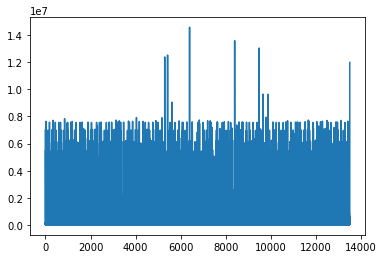

In [72]:
plt.plot(loss_values[500:])

In [79]:
new_vae = VAE(latent_dim)
new_vae.load_state_dict(trained_model.state_dict())

RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encoder_before_last.4.0.weight", "encoder_before_last.4.0.bias", "encoder_before_last.5.0.weight", "encoder_before_last.5.0.bias", "encoder_before_last.6.0.weight", "encoder_before_last.6.0.bias", "encoder_before_last.8.0.weight", "encoder_before_last.8.0.bias", "encoder_before_last.9.0.weight", "encoder_before_last.9.0.bias", "decoder.5.0.weight", "decoder.5.0.bias", "decoder.6.1.weight", "decoder.6.1.bias", "decoder.7.0.weight", "decoder.7.0.bias", "decoder.8.1.weight", "decoder.8.1.bias", "decoder.9.0.weight", "decoder.9.0.bias". 
	Unexpected key(s) in state_dict: "encoder_before_last.0.1.weight", "encoder_before_last.0.1.bias", "encoder_before_last.0.1.running_mean", "encoder_before_last.0.1.running_var", "encoder_before_last.0.1.num_batches_tracked", "encoder_before_last.1.1.weight", "encoder_before_last.1.1.bias", "encoder_before_last.1.1.running_mean", "encoder_before_last.1.1.running_var", "encoder_before_last.1.1.num_batches_tracked", "encoder_before_last.2.1.weight", "encoder_before_last.2.1.bias", "encoder_before_last.2.1.running_mean", "encoder_before_last.2.1.running_var", "encoder_before_last.2.1.num_batches_tracked", "encoder_before_last.3.1.weight", "encoder_before_last.3.1.bias", "encoder_before_last.3.1.running_mean", "encoder_before_last.3.1.running_var", "encoder_before_last.3.1.num_batches_tracked", "decoder.1.1.weight", "decoder.1.1.bias", "decoder.1.1.running_mean", "decoder.1.1.running_var", "decoder.1.1.num_batches_tracked", "decoder.2.1.weight", "decoder.2.1.bias", "decoder.2.1.running_mean", "decoder.2.1.running_var", "decoder.2.1.num_batches_tracked", "decoder.3.0.weight", "decoder.3.0.bias", "decoder.3.1.running_mean", "decoder.3.1.running_var", "decoder.3.1.num_batches_tracked", "decoder.4.1.weight", "decoder.4.1.bias", "decoder.4.1.running_mean", "decoder.4.1.running_var", "decoder.4.1.num_batches_tracked". 
	size mismatch for encoder_before_last.0.0.weight: copying a param with shape torch.Size([32, 1, 6, 6]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for encoder_before_last.0.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder_before_last.1.0.weight: copying a param with shape torch.Size([32, 32, 6, 6]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for encoder_before_last.1.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder_before_last.2.0.weight: copying a param with shape torch.Size([32, 32, 6, 6]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for encoder_mu.0.weight: copying a param with shape torch.Size([20, 960]) from checkpoint, the shape in current model is torch.Size([20, 1024]).
	size mismatch for encoder_log_var.0.weight: copying a param with shape torch.Size([20, 960]) from checkpoint, the shape in current model is torch.Size([20, 1024]).
	size mismatch for decoder.0.0.weight: copying a param with shape torch.Size([960, 20]) from checkpoint, the shape in current model is torch.Size([1024, 20]).
	size mismatch for decoder.0.0.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.1.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for decoder.1.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.2.0.weight: copying a param with shape torch.Size([32, 32, 6, 6]) from checkpoint, the shape in current model is torch.Size([6144, 1024]).
	size mismatch for decoder.2.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([6144]).
	size mismatch for decoder.3.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for decoder.3.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.4.0.weight: copying a param with shape torch.Size([32, 1, 6, 6]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for decoder.4.0.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([64]).

In [75]:
# torch.manual_seed(50)
samples = new_vae.generate_sample(6).detach().numpy()
# ori_sample = mnist_train[4][0]
# plt.figure()
# plt.imshow(ori_sample.reshape((24,256)).detach().numpy())
# samples, _, _ = new_vae(ori_sample.reshape((1,1,24,256)))
# samples = samples.detach().numpy()
for s in range(samples.shape[0]):
    sample = samples[s,0,:,0:24].reshape(24,24)
    plt.figure()
    plt.imshow(sample)

tensor([[ 7.9547e-01,  6.9035e-01,  4.2320e-01,  8.3899e-01,  1.8401e+00,
         -3.1977e-01, -1.3820e+00,  1.0102e+00,  1.1069e+00,  2.2843e+00,
         -1.0792e+00,  1.4654e-01, -5.1629e-01, -2.0900e-01, -1.2662e+00,
         -7.9639e-01, -9.2992e-01, -2.1113e+00, -1.1167e+00,  2.3875e-01],
        [-1.0631e-01, -5.8683e-01, -7.7416e-01,  2.0739e-01,  1.0154e+00,
         -2.5371e-01,  6.2102e-01,  5.2228e-01,  1.5081e+00,  3.6975e-01,
         -7.0279e-01, -3.5281e-02, -2.0121e+00,  1.0677e+00, -7.4286e-01,
         -2.0439e-01,  4.1116e-01, -1.2027e+00,  5.0998e-01, -6.1429e-01],
        [ 1.2173e+00,  4.7351e-01,  6.5448e-01,  1.4108e-01,  9.5603e-01,
          1.1715e-01, -7.4444e-01, -1.1165e-01, -1.9058e+00,  7.7139e-01,
         -5.7533e-01, -1.7457e+00,  4.3733e-01, -2.4241e-01, -1.5167e+00,
          2.7018e-01, -8.8540e-01, -4.1748e-01,  4.9366e-01,  2.0629e+00],
        [ 5.3454e-01, -1.4806e-01,  1.5921e+00, -1.1720e+00, -1.2667e-01,
          1.1965e-01, -2.0763e-01, 

RuntimeError: Tensor for argument #2 'mat1' is on CPU, but expected it to be on GPU (while checking arguments for addmm)

In [76]:
samples = new_vae.generate_sample(4).detach().numpy()
plot_raw_EEG(samples, 4)

tensor([[ 8.7327e-01,  3.9402e-01, -6.2465e-01,  2.2191e-01,  1.5748e+00,
          8.0359e-01, -3.8358e-01, -1.1939e+00,  1.6041e-01,  8.0763e-01,
         -5.2352e-01,  4.2479e-01, -2.4660e+00,  1.0039e-01, -1.0736e+00,
         -8.4946e-02, -2.8789e-01, -6.3067e-01,  1.0571e-01, -6.5155e-01],
        [ 9.0570e-01,  4.0763e-01,  2.6847e-01, -1.8115e+00, -1.3229e+00,
         -1.0190e+00,  6.2301e-01,  8.2672e-01,  4.1756e-02, -9.3596e-01,
          3.0391e-01,  7.4677e-01,  6.2171e-01,  7.2820e-01,  9.3001e-02,
         -2.6045e+00,  1.0015e+00,  4.7062e-01,  5.7917e-01,  1.2868e-02],
        [-1.7190e+00,  7.2532e-01, -2.2010e-03, -4.9515e-01, -2.0029e-01,
          1.2886e+00,  4.5963e-03,  1.1657e+00,  3.9207e-01,  7.3427e-01,
          2.0963e+00, -3.6145e-01, -4.1840e-01,  1.0191e+00,  7.4579e-01,
          1.0750e+00,  3.7316e-01,  5.6823e-01, -5.0684e-01, -4.6419e-01],
        [ 9.9191e-01, -4.9232e-02,  6.0604e-01, -1.8403e+00,  5.2091e-03,
         -7.3371e-02, -2.3886e+00, 

RuntimeError: Tensor for argument #2 'mat1' is on CPU, but expected it to be on GPU (while checking arguments for addmm)